# 🗺️ Analisis de redes en Python

**Universidad Nacional de Colombia**  

**Desarrollado por:** Yurley Tatiana Prieto  

---

> *This notebook was adapted from:*  
> <https://autogis-site.readthedocs.io/en/2019/notebooks/L6/network-analysis.html>





## 0. Introducción al Análisis de Redes

Las redes —o grafos, para usar el término matemático— proporcionan un marco poderoso para modelar y analizar relaciones entre entidades. En su forma más simple, un grafo consta de:

* **Nodos (vértices)** : los objetos o entidades que participan en las relaciones (personas, ciudades, genes, etc.).
* 
* **Aristas (enlaces)** (links):las conexiones que unen pares de nodos y describen una relación específica (amistad, carretera, interacción biológica, entre otras).

Tanto los nodos como las aristas pueden contener metadatos en forma de pares clave–valor. Por ejemplo, en una red social los nodos “Hugo” y “Eric” podrían tener un atributo  `{ "age": 25 }`, mientras que la arista entre ellos podría almacenar `{ "first_met": "2016-05-21" }`.

### ¿Por qué modelar los datos como una red?

Representar los datos como un grafo permite abordar preguntas que son difíciles de responder con tablas convencionales, como:

* ¿Quiénes son los influenciadores clave dentro de una comunidad en línea?  
* ¿Cuál es la ruta óptima entre dos ciudades en una red de transporte?  
* ¿Existen agrupamientos o comunidades densamente conectadas en la red?


Encontrar un camino más corto usando una red vial específica es un problema común en los SIG (Sistemas de Información Geográfica) que tiene muchas aplicaciones prácticas. Por ejemplo, la navegación, una de esas aplicaciones para la cual se utilizan algoritmos de enrutamiento para encontrar la ruta óptima entre dos o más puntos.

Al examinar la estructura de un grafo, podemos calcular métricas a nivel de nodo (por ejemplo, centralidad), identificar puentes críticos o detectar agrupaciones comunitarias naturales.

En Python, la biblioteca **NetworkX** (importada como nx) proporciona una API intuitiva para crear, manipular y visualizar grafos en memoria.



[1, 2, 3]
[(1, 2)]


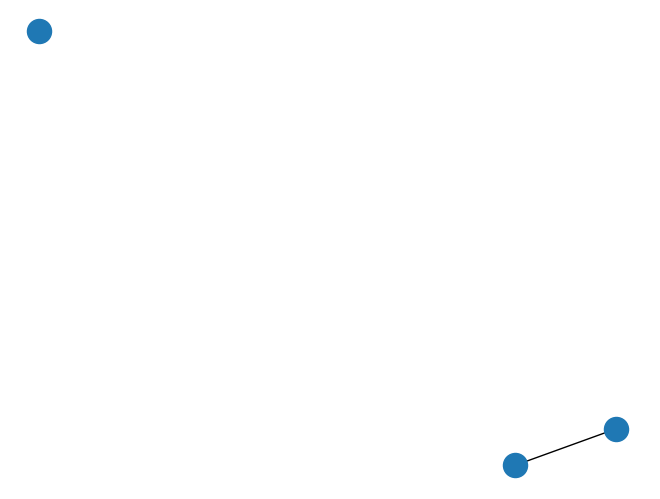

In [1]:
# Importamos la libreria 
import networkx as nx

# Crear un grafo vacío y no dirigido
G = nx.Graph()

# Agregar nodos y una arista
G.add_nodes_from([1, 2, 3])
G.add_edge(1, 2)

# Inspeccionar nodos y aristas
print(G.nodes())    # → [1, 2, 3]
print(G.edges())    # → [(1, 2)]

# Adjuntar metadatos
G.nodes[1]["label"] = "blue"

# Visualización básica (requiere matplotlib.pyplot como plt)
nx.draw(G)


## 1. Obtain a routable network

To download OpenStreetMap data that represents the street network, we can use
it’s
[`graph_from_place()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place)
function. As parameters, it expects a place name and, optionally, a network
type.

In [2]:
# Descargar librería para trabajar OpenStreetMap

!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 3.1 MB/s eta 0:00:00


La biblioteca NetworkX ofrece herramientas para analizar redes e implementar algoritmos de enrutamiento como Dijkstra y A*, usados para hallar rutas más cortas en redes de transporte.

Para realizar este tipo de análisis, necesitamos una red. La biblioteca OSMnx permite obtener redes enrutables desde OpenStreetMap, adaptadas para caminar, andar en bicicleta o conducir. Además, facilita el uso de NetworkX sobre estos datos.

En la siguiente sección, usaremos OSMnx para encontrar la ruta más corta entre dos puntos a través de vías ciclables, y con mínimas modificaciones, también podremos hacerlo sobre la red peatonal.

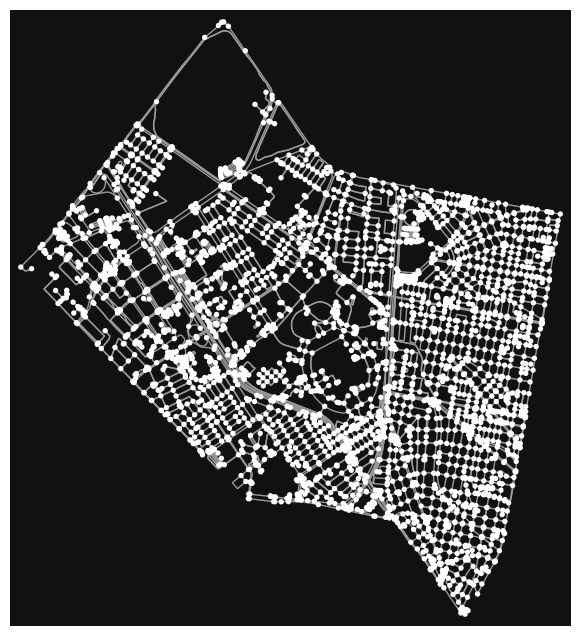

In [4]:
import osmnx
PLACE_NAME = "teusaquillo, Bogotá, Colombia"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="bike"
)
figure, ax = osmnx.plot_graph(graph)

> **Pro tip!**  
> Sometimes the shortest path might go slightly outside the defined area of interest. To account for this, we can fetch the network for a bit larger area than the district of Kamppi, in case the shortest path is not completely inside its boundaries.

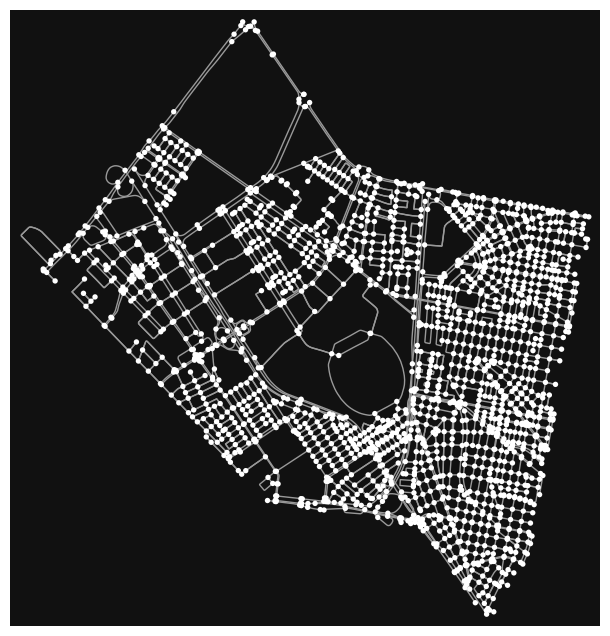

In [5]:
# Obtener el polígono del área de interés
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Reproyectar el polígono a un sistema de coordenadas proyectado local (Magna Sirgas Bogotá)
place_polygon = place_polygon.to_crs("EPSG:3067")

# Aplicar un buffer de 200 metros
place_polygon["geometry"] = place_polygon.buffer(200)

# Reproyectar el polígono nuevamente a WGS84
place_polygon = place_polygon.to_crs("EPSG:4326")

# Obtener la red de calles dentro del polígono
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="drive"
)

fig, ax = osmnx.plot_graph(graph)

### 1.1. Descripción general de los datos

Una vez obtenida la red para el modo de viaje seleccionado (bicicleta), podemos examinar qué atributos tienen sus nodos y aristas. Para facilitar el análisis, es útil convertir la red en un GeoDataFrame, lo cual nos permite aplicar las herramientas vistas anteriormente.

Para ello, usamos la función`osmnx.graph_to_gdfs()`, que permite extraer solo los nodos, solo las aristas o ambos (por defecto).

In [6]:
# Obtener solo las aristas del grafo
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid      highway lanes        name  oneway  \
u         v          key                                                     
253762003 500959293  0     24350411  residential     2  Carrera 24    True   
          264153961  0     89574149  residential     2    Calle 27    True   
253762008 500959410  0     89574149  residential     2    Calle 27    True   
          2863370701 0    282426636  residential   NaN  Carrera 27    True   
254530330 263368983  0     25973462  residential     2  Carrera 22    True   

                         reversed     length maxspeed  \
u         v          key                                
253762003 500959293  0      False  54.439641      NaN   
          264153961  0      False  91.009857       30   
253762008 500959410  0      False  89.638377       30   
          2863370701 0      False  57.524251      NaN   
254530330 263368983  0      False  90.869452      NaN   

                                                                   geometry  \
u         v          key                                                      
253762003 500959293  0    LINESTRING (-74.07673 4.62248, -74.07632 4.62275)   
          264153961  0    LINESTRING (-74.07673 4.62248, -74.07633 4.62176)   
253762008 500959410  0    LINESTRING (-74.07763 4.62377, -74.07716 4.62311)   
          2863370701 0     LINESTRING (-74.07763 4.62377, -74.0772 4.62405)   
254530330 263368983  0    LINESTRING (-74.07118 4.65073, -74.07119 4.650...   

                         junction bridge access width area tunnel  
u         v          key                                           
253762003 500959293  0        NaN    NaN    NaN   NaN  NaN    NaN  
          264153961  0        NaN    NaN    NaN   NaN  NaN    NaN  
253762008 500959410  0        NaN    NaN    NaN   NaN  NaN    NaN  
          2863370701 0        NaN    NaN    NaN   NaN  NaN    NaN  
254530330 263368983  0        NaN    NaN    NaN   NaN  NaN    NaN

El GeoDataFrame resultante contiene una larga lista de columnas. La mayoría provienen de etiquetas de OpenStreetMap, y sus nombres son bastante autoexplicativos. Las columnas u y v describen la relación topológica dentro de la red: indican el nodo de inicio y el nodo final de cada arista.

| Column                                                                 | Description                         | Data type         |
|------------------------------------------------------------------------|-------------------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)                | Indica si es un puente              | boolean           |
| geometry                                                              | Geometría del elemento             | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)              | Etiqueta para tipo de vía           | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)                  | Número de carriles                     | int (or nan)      |
| [length](http://wiki.openstreetmap.org/wiki/Key:length)                | Longitud del elemento (en metros)          | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)            | Límite máximo de velocidad legal           | int / list        |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)                    | Nombre del elemento (por ejemplo, calle)        | str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)                | Indica si la vía es en un solo sentido                        | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)                       | IDs únicos del elemento          | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                                         | Nodo de inicio de la arista              | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                                         | Nodo final de la arista                | int               |



¿Qué tipos de calles componen nuestra red?

In [7]:
edges["highway"].value_counts()

highway
residential               2654
secondary                  657
tertiary                   590
primary                    154
trunk                       84
primary_link                53
trunk_link                  37
secondary_link              34
unclassified                24
tertiary_link               15
[residential, primary]       1
Name: count, dtype: int64

### 1.2. Transformar al sistema de referencia proyectado

La red descargada usa WGS84 (EPSG:4326), un sistema geográfico que expresa distancias en grados, lo cual no es adecuado para análisis de redes como rutas más cortas.

Aunque los grafos de OSMnx no permiten cambiar directamente su sistema de referencia, podemos usar la función:
[`osmnx.project_graph()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph)
que transforma el grafo a un CRS proyectado. Si no se especifica uno, aplica automáticamente la zona UTM más adecuada para el área.

In [8]:
# Transformar el grafo a UTM
graph = osmnx.project_graph(graph) 

# Extraer los nodos y aristas reproyectados
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

---


## 2. Análisis de propiedades de la red

Ahora que ya contamos con un grafo enrutado, podemos utilizar las funciones analíticas de OSMnx para extraer información sobre la red. Para calcular características básicas, usamos la función
[`osmnx.basic_stats()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats):

In [9]:
# Calcular estadísticas básicas de la red
osmnx.basic_stats(graph)

{'n': 2049,
 'm': 4303,
 'k_avg': 4.200097608589556,
 'edge_length_total': 370662.37169766484,
 'edge_length_avg': 86.14045356673596,
 'streets_per_node_avg': 3.2357247437774523,
 'streets_per_node_counts': {0: 0, 1: 102, 2: 8, 3: 1257, 4: 670, 5: 11, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.04978038067349927,
  2: 0.003904343582235237,
  3: 0.6134699853587116,
  4: 0.3269887750122011,
  5: 0.005368472425573451,
  6: 0.0004880429477794046},
 'intersection_count': 1947,
 'street_length_total': 283418.05918494303,
 'street_segment_count': 3255,
 'street_length_avg': 87.07160036403779,
 'circuity_avg': 1.0374789666762185,
 'self_loop_proportion': 0.0}

Esto aún no proporciona todas las características relevantes de la red, ya que OSMnx no considera automáticamente el área que cubre. Para calcularla manualmente, primero debemos delinear el envolvente complejo de la red (una unión única de todas sus geometrías), y luego calcular su área.

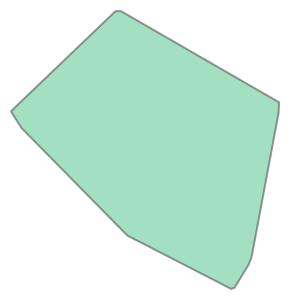

In [10]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [11]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 2049,
 'm': 4303,
 'k_avg': 4.200097608589556,
 'edge_length_total': 370662.37169766484,
 'edge_length_avg': 86.14045356673596,
 'streets_per_node_avg': 3.2357247437774523,
 'streets_per_node_counts': {0: 0, 1: 102, 2: 8, 3: 1257, 4: 670, 5: 11, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.04978038067349927,
  2: 0.003904343582235237,
  3: 0.6134699853587116,
  4: 0.3269887750122011,
  5: 0.005368472425573451,
  6: 0.0004880429477794046},
 'intersection_count': 1947,
 'street_length_total': 283418.05918494303,
 'street_segment_count': 3255,
 'street_length_avg': 87.07160036403779,
 'circuity_avg': 1.0374789666762185,
 'self_loop_proportion': 0.0,
 'node_density_km': 120.56133266223091,
 'intersection_density_km': 114.55974362780067,
 'edge_density_km': 21809.443386829505,
 'street_density_km': 16676.065844743665}

### 2.1. 🚀 ** Explorando atributos de las calles**

1. **Calculate** la longitud total de las calles clasificadas como `residential`, `primary`, and `secondary`.  

In [21]:
edges_Copia= edges.copy() # realizamos una copia


In [22]:
edges_Copia=edges_Copia.explode("highway")# convertir en cada elemento en una fila


In [23]:
edges_length=(
    edges_Copia.groupby("highway")["length"]
              .sum()
              .sort_values(ascending=False)/1000)
                

# Filtrar el DataFrame para incluir solo las clases deseadas
filtered_edges_length = edges_length.loc[['residential', 'primary', 'secondary']]

# Mostrar el resultado
display(filtered_edges_length)



highway
residential    209.893234
primary         23.331793
secondary       60.132943
Name: length, dtype: float64

 2. **Compare** la longitud media para cada tipo.  

In [24]:
Media_Clase= (
    edges_Copia.groupby("highway")["length"]
    .mean()
    .sort_values(ascending=False)
)

display(Media_Clase)

highway
unclassified      311.548141
trunk             158.747909
primary           150.527700
primary_link      129.360060
trunk_link        115.417839
secondary          91.526550
residential        79.055832
tertiary           73.646769
secondary_link     51.448385
tertiary_link      23.374755
Name: length, dtype: float64

3. **Visualise** Visualiza en un gráfico de barras las cinco clases de calle más largas.


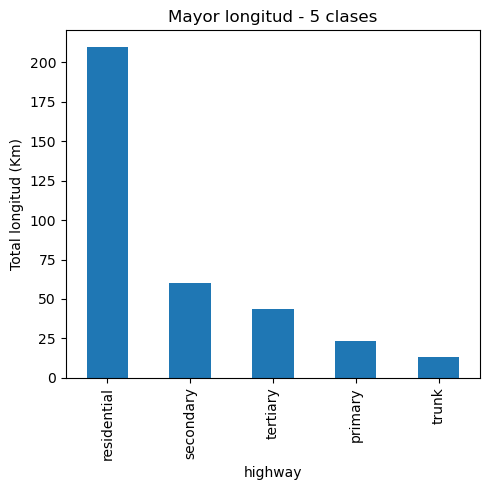

In [26]:
import matplotlib.pyplot as plt

Long_Clase_Km.head(5).plot(kind="bar", figsize=(5, 5))
plt.ylabel("Total longitud (Km)")
plt.title("Mayor longitud - 5 clases")
plt.tight_layout()
plt.show()



## 3. Análisis de rutas más cortas

Vamos a calcular la ruta más corta entre dos puntos usando
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).



### 3.1. Puntos de origen y destino 

Primero, debemos definir los puntos de inicio y fin de la ruta. Puedes usar nombres personalizados si conoces la zona de Kamppi, o seguir este ejemplo:
- [`"Gran Estación"`]:es un centro comercial moderno de Bogotá, ubicado sobre la Avenida El Dorado, con tiendas, restaurantes y cines.
  
- [`"Estadio Nemesio Camacho El Campín"`]: Principal estadio de fútbol de Bogotá y uno de los más emblemáticos de Colombia. Inaugurado en 1938, es sede de los equipos Santa Fe y Millonarios, y también alberga conciertos y eventos culturales de gran escala.

Aunque podríamos obtener manualmente las coordenadas y crear objetos Point, esto se vuelve tedioso con más puntos. Por eso, usaremos OSMnx para geocodificar los lugares.

Recuerda: los puntos de origen y destino deben estar en el mismo sistema de referencia espacial que la red.


In [30]:
origin = (
    osmnx.geocode_to_gdf("Estadio Nemesio Camacho El Campín, bogota") # obtener la geolocalización
    .to_crs(edges.crs)  # transformar a UTM (mismo CRS que la red)
    .at[0, "geometry"]   # seleccionar la geometría de la primera fila
    .centroid  # usar el punto central
)

destination = (
    osmnx.geocode_to_gdf("Gran Estación,Teusaquillo, Bogotá")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

Ahora tenemos objetos `shapely.geometry.Point`que representan los puntos de origen y destino para nuestro análisis de red. El siguiente paso es ubicarlos dentro de la red enrutada antes de calcular la ruta final.


### 3.2. Nodo más cercano

Para enrutar dentro de la red, primero debemos encontrar el nodo más cercano al punto de origen y al de destino. Para esto usamos
`[osmnx.distance.nearest_nodes()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes)
que devuelve el ID del nodo más próximo.

In [31]:
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

263368698

In [32]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

560635265

### 3.3.  Enrutamiento

Ya estamos listos para calcular la ruta más corta entre los puntos de origen y destino, usando
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).

Esta función requiere tres parámetros obligatorios: el grafo, el ID del nodo de origen y el ID del nodo de destino. También admite parámetros opcionales como weight (para usar un criterio diferente al de distancia) y cpus (para cálculo en paralelo de múltiples rutas).

In [33]:
# Find the shortest path between origin and destination
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
route

[263368698,
 262713328,
 5539209176,
 5174956921,
 263544304,
 263544307,
 263544308,
 262713337,
 262713447,
 262713336,
 9450777889,
 5754981476,
 5754981457,
 2437644151,
 4785533433,
 4090491902,
 4090491553,
 262545887,
 262546041,
 254530369,
 262419941,
 262419956,
 3175083680,
 261188868,
 261188867,
 261188963,
 261188960,
 469488796,
 5163571786,
 5163571783,
 469488747,
 832320786,
 312763315,
 312763487,
 312763783,
 9354008776,
 4281292669,
 535576179,
 535576172,
 4281285221,
 312764859,
 5657916829,
 560635265]

El resultado es una lista de nodos que conforman la ruta más corta. Aunque podríamos construir manualmente una LineString con sus coordenadas, OSMnx simplifica este proceso: podemos usar la función`plot_graph_route()`para visualizar directamente la ruta.

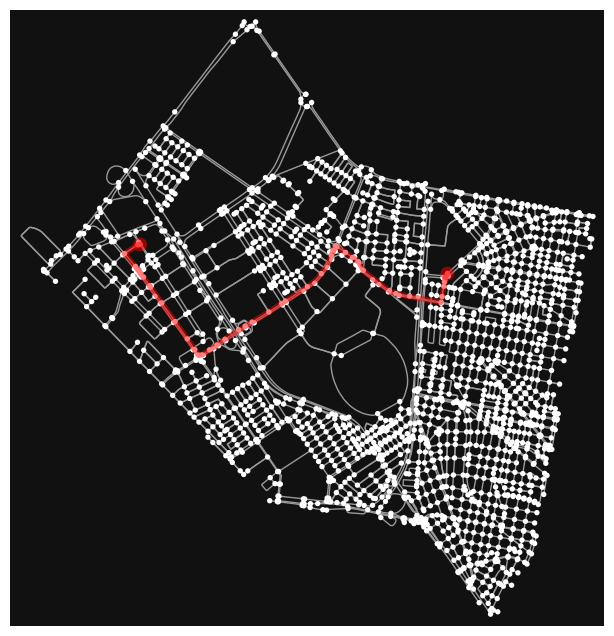

In [34]:
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, route)

### 3.4. 🚀 **Rutas alternativas**

1. **Calcula** a segunda ruta que evite vías tipo `motorway` y  `trunk` 

In [54]:
# Velocidades promedio (en km/h)
velocidades = {
    "motorway": 80,
    "trunk": 60,
    "primary": 50,
    "secondary": 40,
    "tertiary": 30,
    "residential": 20,
    "living_street": 10,
    "default": 25
}

# Agregar travel_time a cada arista
for u, v, k, data in graph.edges(keys=True, data=True):
    tipo = data.get("highway", "default")
    if isinstance(tipo, list):
        tipo = tipo[0]  # tomar el primer tipo si es lista
    velocidad_kmh = velocidades.get(tipo, velocidades["default"])
    velocidad_mps = velocidad_kmh * 1000 / 3600  # convertir a m/s

    if "length" in data:
        data["travel_time"] = data["length"] / velocidad_mps  # en segundos

In [55]:
# ruta mas optima por tiempo 
route_tiempo = nx.shortest_path(graph, origin_node_id, destination_node_id, weight="travel_time")


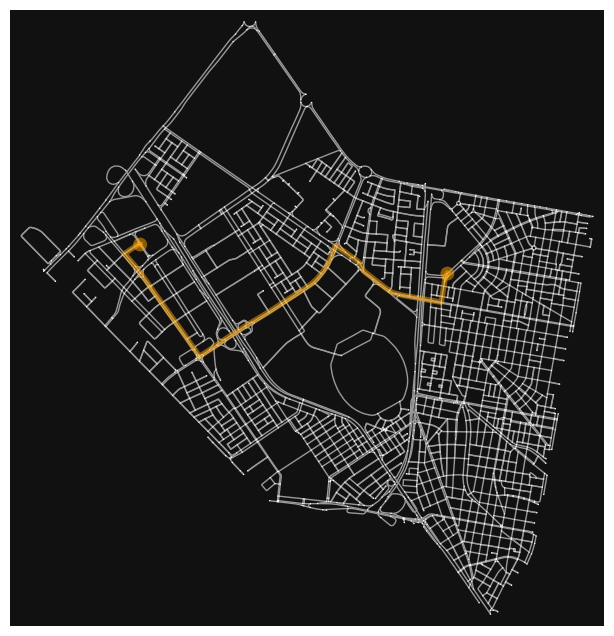

In [58]:
fig, ax = osmnx.plot_graph_routes(
    graph,
    routes=[route_tiempo],
    route_colors=["orange"],  # naranja = ruta más rápida por tiempo
    route_linewidth=3,
    node_size=1,
    show=False,
    close=False
)

2. **Compara** su longitud con la ruta más corta original.  

In [56]:

def calcular_total(graph, route, atributo):
    total = 0
    for u, v in zip(route[:-1], route[1:]):
        edges = graph.get_edge_data(u, v)
        if edges:
            valor = min(attr.get(atributo, 0) for attr in edges.values())
            total += valor
    return total

# Calcular métricas
distancia_ruta = calcular_total(graph, route, "length")
tiempo_ruta = calcular_total(graph, route, "travel_time")

distancia_tiempo = calcular_total(graph, route_tiempo, "length")
tiempo_tiempo = calcular_total(graph, route_tiempo, "travel_time")

# Mostrar resultados
print(f"Ruta más corta por distancia: {distancia_ruta:.2f} m / {tiempo_ruta:.1f} s")
print(f"Ruta más rápida por tiempo:    {distancia_tiempo:.2f} m / {tiempo_tiempo:.1f} s")
print(f"Diferencia de tiempo: {tiempo_ruta - tiempo_tiempo:.1f} s")


Ruta más corta por distancia: 4462.44 m / 426.9 s
Ruta más rápida por tiempo:    4473.05 m / 426.2 s
Diferencia de tiempo: 0.7 s


In [22]:
Aunque la diferencia entre la ruta más corta y la más rápida es mínima —menos de un segundo—,
las rutas restringidas o personalizadas pueden ser especialmente útiles para usuarios con necesidades específicas, 
como ciclistas que prefieren evitar vías rápidas, peatones que buscan mayor seguridad, o vehículos de emergencia 
que requieren trayectos más fluidos. Incluso cuando la ganancia en tiempo es marginal, estas rutas pueden ofrecer 
mayor comodidad, accesibilidad o seguridad según el perfil del usuario.



## 4. Guardar rutas más cortas en disco

Con frecuencia, es necesario guardar la ruta en un archivo para realizar análisis o visualizaciones posteriores, o al menos conservarla como un objeto GeoDataFrame en Python. Por eso, continuaremos un poco más y veremos cómo convertir la ruta en una línea geométrica (LineString) y guardar su geometría junto con los atributos relacionados en un archivo GeoPackage.

Primero, debemos obtener los nodos que pertenecen a la ruta más corta:

In [59]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
route_nodes

,y,x,street_count,highway,railway,geometry
osmid,,,,,,
263368698,513471.575972,602401.199124,3,traffic_signals,NaN,POINT (602401.199 513471.576)
262713328,513436.375519,602383.663208,4,traffic_signals,NaN,POINT (602383.663 513436.376)
5539209176,513412.598580,602377.293767,3,NaN,NaN,POINT (602377.294 513412.599)
5174956921,513393.679082,602374.157041,3,NaN,NaN,POINT (602374.157 513393.679)
263544304,513353.385090,602367.309964,4,traffic_signals,NaN,POINT (602367.31 513353.385)
263544307,513257.438289,602351.173228,4,NaN,NaN,POINT (602351.173 513257.438)
263544308,513204.318719,602343.111545,3,NaN,NaN,POINT (602343.112 513204.319)
262713337,513285.079978,601920.719662,3,NaN,NaN,POINT (601920.72 513285.08)
262713447,513311.788610,601860.607177,3,NaN,NaN,POINT (601860.607 513311.789)


As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

Now we can create a LineString out of the Point geometries of the nodes:

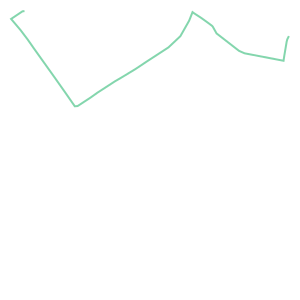

In [60]:
import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

Now we have the route as a LineString geometry. 

Let's make a GeoDataFrame out of it having some useful information about our
route such as a list of the osmids that are part of the route and the length
of the route.

In [61]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (602401.199 513471.576, 602383.663 ...","[263368698, 262713328, 5539209176, 5174956921,...",4448.05006


Now we have a GeoDataFrame that we can save to disk. Let's still confirm that
everything is ok by plotting our route on top of our street network and some
buildings, and plot also the origin and target points on top of our map.

Download buildings:

In [62]:
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

Let's now plot the route and the street network elements to verify that
everything is as it should:

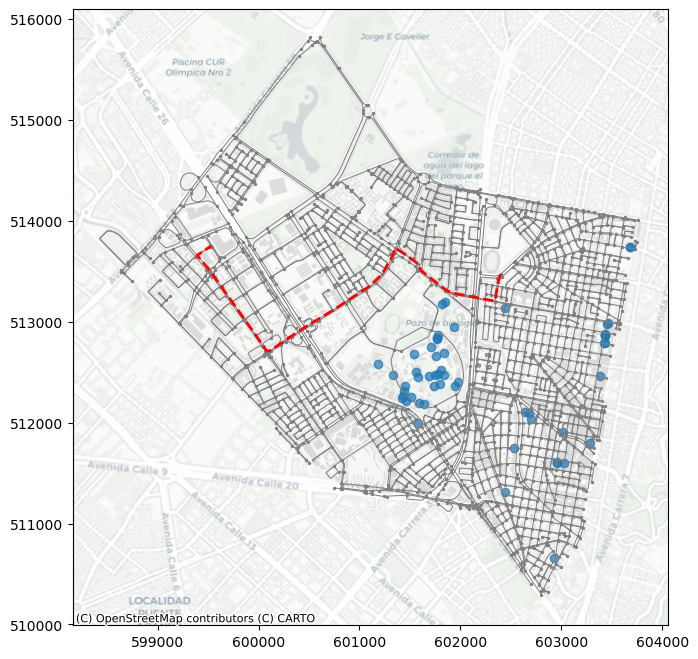

In [63]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

Great everything seems to be in order! As you can see, now we have a full
control of all the elements of our map and we can use all the aesthetic
properties that matplotlib provides to modify how our map will look like. Now
we are almost ready to save our data into disk.



## Prepare data for saving to file

The data contain certain data types (such as `list`) that should be converted
into character strings prior to saving the data to file (an alternative would be
to drop invalid columns).

In [64]:
edges.head()

osmid      highway lanes        name  oneway  \
u         v         key                                                     
253762003 500959293 0     24350411  residential     2  Carrera 24    True   
          264153961 0     89574149  residential     2    Calle 27    True   
500959293 261673627 0     24350411  residential     2  Carrera 24    True   
264153961 264153963 0    741813349  residential     2    Calle 27   False   
          264153953 0    908612686  residential     2  Carrera 23   False   

                        reversed      length maxspeed  \
u         v         key                                 
253762003 500959293 0      False   54.439641      NaN   
          264153961 0      False   91.009857       30   
500959293 261673627 0      False   54.151701      NaN   
264153961 264153963 0      False  112.406708       30   
          264153953 0       True   65.874503      NaN   

                                                                  geometry  \
u         v         key                                                      
253762003 500959293 0    LINESTRING (602409.563 511000.479, 602455.05 5...   
          264153961 0    LINESTRING (602409.563 511000.479, 602453.716 ...   
500959293 261673627 0    LINESTRING (602455.05 511030.277, 602493.795 5...   
264153961 264153963 0    LINESTRING (602453.716 510921.337, 602477.739 ...   
          264153953 0    LINESTRING (602453.716 510921.337, 602401.274 ...   

                        junction access bridge width area tunnel  
u         v         key                                           
253762003 500959293 0        NaN    NaN    NaN   NaN  NaN    NaN  
          264153961 0        NaN    NaN    NaN   NaN  NaN    NaN  
500959293 261673627 0        NaN    NaN    NaN   NaN  NaN    NaN  
264153961 264153963 0        NaN    NaN    NaN   NaN  NaN    NaN  
          264153953 0        NaN    NaN    NaN   NaN  NaN    NaN

In [66]:
# Columnas con valores no válidos
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "access",   
]

# Convertir las columnas seleccionadas a formato cadena
edges[problematic_columns] = edges[problematic_columns].astype(str)


In [67]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)

Now we can see that most of the attributes are of type `object` that quite
often (such as ours here) refers to a string type of data.

## Save the data:

In [68]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [ ]:
**Crear** un buffer de 50 m alrededor de la ruta y seleccionar los edificios que la cruzan.

In [71]:
buffer_50m = route_line.buffer(50)

In [ ]:
**Contar** los edificios en total y por etiqueta `building` dentro de este corredor.

In [72]:
buildings_near = buildings[buildings.intersects(buffer_50m)]


In [73]:
buildings_near["building"].value_counts()

building
yes            107
apartments      23
residential      6
stadium          1
university       1
commercial       1
Name: count, dtype: int64

In [ ]:
**Exportar** el resultado a `buildings_along_route.geojson`. 

In [74]:
buildings_near.to_file("buildings_near.geojson", driver="GeoJSON")

Ahora es posible comparar los algoritmos de Dijkstra y A* para analizar si existen diferencias en las rutas generadas sobre la misma red.

El primer paso consiste en definir criterios claros para la medida de distancia que utilizará el algoritmo A*. En este caso, se compararán dos heurísticas: la distancia euclidiana y la distancia Manhattan.

In [75]:
def euclidean_heuristic(u, v):
    ux, uy = graph.nodes[u]['x'], graph.nodes[u]['y']
    vx, vy = graph.nodes[v]['x'], graph.nodes[v]['y']
    return ((ux - vx)**2 + (uy - vy)**2)**0.5
def manhattan_heuristic(u, v):
    ux, uy = graph.nodes[u]['x'], graph.nodes[u]['y']
    vx, vy = graph.nodes[v]['x'], graph.nodes[v]['y']
    return abs(ux - vx) + abs(uy - vy)


In [ ]:
Se pueden reutilizar los mismos nodos de origen y destino, pero ahora empleando el algoritmo A* junto con las heurísticas previamente definidas.
Para ello, basta con invocar el comando correspondiente y aplicar las funciones de distancia (euclidiana o Manhattan) como parte del proceso de búsqueda.

In [77]:
route_astar = nx.astar_path(
    graph,
    origin_node_id,
    destination_node_id,
    heuristic=euclidean_heuristic,
    weight="length"
)

route_astar1 = nx.astar_path(
    graph,
    origin_node_id,
    destination_node_id,
    heuristic=manhattan_heuristic,
    weight="length"
)

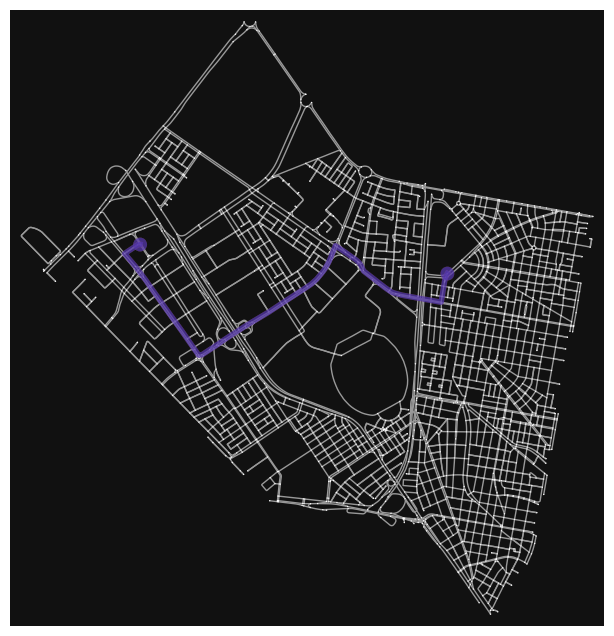

In [79]:
fig, ax = osmnx.plot_graph_routes(
    graph,
    routes=[route_astar, route_astar1],
    route_colors=["orange", "blue"],
    route_linewidth=3,
    node_size=1
)